In [3]:
import sys
path = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/l_sam_env/lib/python3.10/site-packages"

if path not in sys.path: sys.path.append(path)

path2 = "/usr/lib/python3/dist-packages"

if path2 not in sys.path: sys.path.append(path2)

In [70]:
import os
import time
from accelerate import Accelerator 
from accelerate.utils import set_seed


import torch
import torch.nn.functional as F
from box import Box
from config import cfg
from dataset import load_datasets
from losses import DiceLoss
from losses import FocalLoss
from new_model import Model
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
from segment_anything.modeling import Sam
from torch.utils.data import DataLoader
from utils import AverageMeter
from utils import calc_iou
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt


def show_anns(anns,ax):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)           

def main(cfg):
    
    sam_model = sam_model_registry[cfg.model.type](checkpoint=cfg.model.checkpoint)

    path = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/lightning_sam/out/training/mask_decoder2_epochs.pth"

    path = "/home/someone/stage_jonathan/lightning-sam/lightning-sam/lightning_sam/out/training/mask_decoder1_epochs.pth"

    new_mask_decoder = torch.load(path,) # map_location=torch.device('cpu'))

    sam_model.mask_decoder.load_state_dict(new_mask_decoder)

    sam_model = setup_sam(sam_model,cfg)

    model = SamAutomaticMaskGenerator(sam_model,)

    model.predictor.model.to(torch.device("cuda"))
    
    train_data, val_data = load_datasets(cfg, 1024) # hardcoded img size
    
    return model, val_data
    
    
    

In [67]:
cfg.batch_size = 1
cfg.nb_annot = 2

In [60]:
del sam_model, val_data

In [71]:
%matplotlib inline
sam_model, val_data = main(cfg)

loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6065/6065 [00:00<00:00, 12289.18it/s]


Total images: 5936
loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1147/1147 [00:00<00:00, 51838.44it/s]

Total images: 1147


In [72]:
torch.cuda.empty_cache()

In [76]:
image, _, _, gt_masks = next(iter(val_data))

In [87]:
image[0].shape
image_numpy = (255*image[0]).cpu().numpy().transpose(1,2,0).astype(np.uint8)

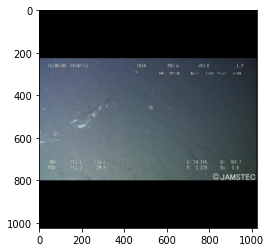

In [88]:
plt.imshow(image_numpy)